CS577 - Assignment 4
<br><br>
Jane Downer<br>
A20452471

## Links to data and trained models
(also included in `data/models.txt`)

In [310]:
google_drive_folder        = 'https://drive.google.com/drive/folders/1ZX6NEp1d4R4q5_Q-Q2ezs3UkRAfOHW1t'
cats_dogs_data_url         = 'https://drive.google.com/file/d/1ztnDOD6dw90iGfS8m2vh4-88cXsPAXvR/view?usp=share_link'
cats_dogs_basic_cnn_url    = 'https://drive.google.com/file/d/1_4q2pE8go_xwm-4yXYArSESDeWoyyETx/view?usp=share_link'
cats_dogs_frozen_vgg_url   = 'https://drive.google.com/file/d/1_06f0cGdpBLPhFyLuE87zVF5hfbteqWU/view?usp=share_link'
cats_dogs_vgg_finetune_url = 'https://drive.google.com/file/d/13zMz1VyhM2eWPHKctqWnMwJ0cVde3Y3L/view?usp=share_link'
cats_dogs_data_augment_url = 'https://drive.google.com/file/d/1nsYcTD_Lwzjii8nO6jV4CL3wCzAw9ZBM/view?usp=share_link'
cifar_data_url             = 'https://drive.google.com/drive/folders/1Wow3Ut8emigYS-_EJAgwUl-8jUnZkBkp?usp=share_link'
cifar_basic_cnn_url        = 'https://drive.google.com/file/d/1S_hzExHbiwPe3lRRSEmeR7_D2Nhzihtc/view?usp=share_link'
cifar_inception_url        = 'https://drive.google.com/file/d/1dkSYU7NeEosfIYMKdBcP0hvuXvb1RZbr/view?usp=share_link'
cifar_residual_url         = 'https://drive.google.com/file/d/1WmXVuMjsyf4TVfvJfqfnqDVyUO1xz1G7/view?usp=share_link'

# Set root path + locations of models

In [327]:
root_dir = '/Users/janedowner/Desktop/Desktop - Jane’s MacBook Pro/CS 577/hw4 - open before submitting'

cats_dogs_data_location = f'{root_dir}/task_1_data.zip'

cats_dogs_basic_cnn_loc    = f'{root_dir}/CatDog_model_8.hdf5'
cats_dogs_frozen_vgg_loc   = f'{root_dir}/VGG_frozen_model.hdf5'
cats_dogs_vgg_finetune_loc = f'{root_dir}/VGG_fine_tuned_model.hdf5'
cats_dogs_data_augment_loc = f'{root_dir}/VGG_aug_frozen_model_1e-03.hdf5'

cifar_data_location = f'{root_dir}/cifar-10-batches-py'

cifar_basic_cnn_loc = f'{root_dir}/cifar_model__11.hdf5'
cifar_inception_loc = f'{root_dir}/cifar_inception_model.hdf5'
cifar_residual_loc  = f'{root_dir}/cifar_residual_model.hdf5'

In [2]:
import os
import shutil
import tensorflow as tf
import tensorflow as tf_not_eager
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import splitfolders
import PIL
import zipfile
import sys
import tarfile
import tensorflow.keras.utils as np_utils
from tensorflow.keras.preprocessing.image import array_to_img, load_img, img_to_array
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
import warnings

tf.compat.v1.enable_eager_execution()
tf_not_eager.compat.v1.disable_eager_execution()
warnings.filterwarnings("ignore")
tf.config.set_visible_devices([], 'GPU')

# Binary Classification

## (a) Import data

In [328]:
'''
Option: if you download data subset from shared folder, uncomment and run this cell 
to avoid the next several blocks of code
'''

# # Uncomment:
# data_zip = cats_dogs_data_location
# with zipfile.ZipFile(data_zip, 'r') as zf:
#     zf.extractall(root_dir)
# task_1_data_dir = f'{root_dir}/task_1_data'

'''
Resume notebook at markdown cell marked with (*)
''';

In [319]:
os.chdir(root_dir)
%cd $root_dir
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

data_zip = f'{root_dir}/kagglecatsanddogs_5340.zip'
 
    
with zipfile.ZipFile(data_zip, 'r') as zf:
    zf.extractall(root_dir)
    
os.remove(data_zip)
os.remove(f'{root_dir}/CDLA-Permissive-2.0.pdf')
os.remove(f'{root_dir}/readme[1].txt')

/Users/janedowner/Desktop/Desktop - Jane’s MacBook Pro/CS 577/hw4 - open before submitting
--2022-11-11 19:38:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 2600:1407:e800:1ae::317f, 2600:1407:e800:1bb::317f, 69.192.209.23
Connecting to download.microsoft.com (download.microsoft.com)|2600:1407:e800:1ae::317f|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  77.4MB/s    in 11s     

2022-11-11 19:38:41 (74.8 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [320]:
all_cat_files = [f'{root_dir}/PetImages/Cat/{filename}' for filename in os.listdir(f'{root_dir}/PetImages/Cat')]
all_dog_files = [f'{root_dir}/PetImages/Dog/{filename}' for filename in os.listdir(f'{root_dir}/PetImages/Dog')]
random.shuffle(all_cat_files)
random.shuffle(all_dog_files)
cat_subset = all_cat_files[:2000]
dog_subset = all_dog_files[:2000]

for (all_files,subset) in [(all_cat_files,cat_subset),(all_dog_files,dog_subset)]:
    if len(all_files) > len(subset):
        for f in all_files:
            if f not in subset:
                try:
                    os.remove(f)
                except:
                    pass

In [321]:
task_1_data_dir = f'{root_dir}/task_1_data'
try:
    os.mkdir(task_1_data_dir)
except:
    pass
try:
    shutil.rmtree(f'{task_1_data_dir}/train/')
    shutil.rmtree(f'{task_1_data_dir}/test')
    shutil.rmtree(f'{task_1_data_dir}/val')
except:
    pass


splitfolders.ratio(f'{root_dir}/PetImages', output=task_1_data_dir, seed=2575, ratio=(.7,0.1,0.2))##,0.2)) 

print('# train images: ' + str(len(os.listdir(f'{task_1_data_dir}/train/Cat'))))
print('# test images:  ' + str(len(os.listdir(f'{task_1_data_dir}/test/Cat'))))
print('# val images:   ' + str(len(os.listdir(f'{task_1_data_dir}/val/Cat'))))

Copying files: 4000 files [00:01, 2543.71 files/s]

# train images: 1400
# test images:  400
# val images:   200


In [322]:
problem_files = []
tasks = ['train','test','val']
for task in tasks:
    folder_path = f'{root_dir}/task_1_data/{task}'
    for fldr in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, fldr)
        sub_folder_size = len(os.listdir(sub_folder_path))
        for i in range(sub_folder_size):
            file_name = os.listdir(sub_folder_path)[i]
            file_path = os.path.join(sub_folder_path, file_name)
            print(f'{i}/{sub_folder_size}', end="\r", flush=True)
            try:
                im = PIL.Image.open(file_path)
                rgb_im = im.convert('RGB')
            except:
                problem_files.append(file_path)
        print()

for pf in problem_files:
    print(pf)
    os.remove(pf)

1399/1400
1399/1400
399/400
399/400
199/200
199/200
/Users/janedowner/Desktop/Desktop - Jane’s MacBook Pro/CS 577/hw4 - open before submitting/task_1_data/test/Cat/666.jpg


## ( * ) If downloaded data subset from shared folder, can resume here:

In [244]:
def image_data_gen(aug=False):
    if aug:
        return ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
    else:
        return ImageDataGenerator(rescale=1./255)

def basic_CNN(h1h2h3=(32,32,32),input_shape=(150,150,3),output_act='sigmoid'):
    (first_dense, output_units) = (True, 1) if output_act=='sigmoid' else (False, 10)
    
    cnn = tf.keras.models.Sequential()

    cnn.add(Conv2D(h1h2h3[0],(3,3),activation='relu',input_shape=input_shape))
    cnn.add(MaxPool2D((2,2)))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(h1h2h3[1],(3,3),activation='relu'))
    cnn.add(MaxPool2D((2,2)))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(h1h2h3[2],(3,3),activation='relu'))
    cnn.add(MaxPool2D((2,2)))
    cnn.add(BatchNormalization())

    cnn.add(Flatten())
    if first_dense:
        cnn.add(Dense(512,activation='relu'))
    cnn.add(Dense(output_units,activation=output_act))

    return cnn

def next_model_number(model_name):
    numbers =[]# [f.split('.')[0][-1] for f in os.listdir(root_dir) if model_name in f and 'hdf5' in f]
    for f in os.listdir(root_dir):
        if model_name in f and 'hdf5' in f:
            try:
                numbers.append(int(f.split('.')[0][-2:]))
            except:
                try:
                    numbers.append(int(f.split('.')[0][-1]))
                except:
                    pass
    try:
        return max(numbers)+1
    except:
        return 1

def plot_results(epochs,hist,title,filename):
    try:
        acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']
    except:
        acc, val_acc = hist['accuracy'], hist['val_accuracy']
    x,y1,y2 = range(epochs), acc, val_acc
    fig = plt.figure(figsize=(4., 4.))
    plt.ylim(0,1.2)
    plt.plot(x,y1,label='train')
    plt.plot(x,y2,label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    if '.png' not in filename:
        plt.savefig(f'{root_dir}/{filename}.png')
    else:
        plt.savefig(f'{root_dir}/{filename}')
    plt.show()

def grid(model_name, trn_iter_, trn_step_, val_iter_, val_step_, lrs, hs, act, in_shape, epochs_,verbose=1):
    L = 'binary_crossentropy' if act=='sigmoid' else 'categorical_crossentropy'
    i=1
    for lr in lrs:
        for (h1,h2,h3) in hs:

            model_number = next_model_number(model_name)
            print(model_number)

            model = basic_CNN(h1h2h3=(h1,h2,h3),
                              input_shape=in_shape,
                              output_act=act)
            
            # compile            
            model.compile(loss=L, optimizer=tf.keras.optimizers.Adam(lr=lr), metrics=['accuracy'])

            # train
            result = model.fit(trn_iter_,
                               steps_per_epoch =trn_step_,
                               validation_data =val_iter_,
                               validation_steps=val_step_,
                               epochs=epochs_,
                               workers=20,
                               verbose=verbose)
            # save
            model.save(f'{root_dir}/{model_name}_{model_number}.hdf5')
            with open (f'{root_dir}/{model_name}_hist_{model_number}','wb') as f:
                pickle.dump(result.history,f)

            plot_results(epochs_,result,f'lr: {lr}, hs: ({h1},{h2},{h3})',f'{model_name}_{model_number}_plot.png')
            print(f'Final training accuracy: {str(round(result.history["accuracy"][-1],3))}')
            print(f'Final validation accuracy: {str(round(result.history["val_accuracy"][-1],3))}')
            i+=1

## (b) Define training, validation, and test data generators

In [323]:
batch_size_1 =32

trn_dir_1 = f'{task_1_data_dir}/train'
tst_dir_1 = f'{task_1_data_dir}/test'
val_dir_1 = f'{task_1_data_dir}/val'

In [324]:
trn_gen_1 = image_data_gen()
val_gen_1 = image_data_gen()
tst_gen_1 = image_data_gen()

trn_iter_1 = trn_gen_1.flow_from_directory(trn_dir_1, target_size=(150,150), batch_size=batch_size_1, class_mode="binary")
val_iter_1 = val_gen_1.flow_from_directory(val_dir_1, target_size=(150,150), batch_size=batch_size_1, class_mode="binary")
tst_iter_1 = tst_gen_1.flow_from_directory(tst_dir_1, target_size=(150,150), batch_size=batch_size_1, class_mode="binary")

trn_stp_1 = int(trn_iter_1.samples/trn_iter_1.batch_size)
val_stp_1 = int(val_iter_1.samples/val_iter_1.batch_size)
tst_stp_1 = int(tst_iter_1.samples/tst_iter_1.batch_size)

Found 2800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.


## (c) and (d) Build CNN, evaluate performance and tune hyperparameters

### Grid search


5


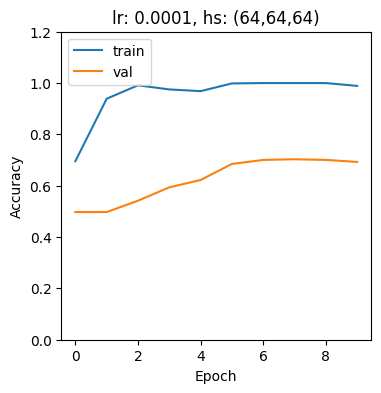

Final training accuracy: 0.989
Final validation accuracy: 0.693

6


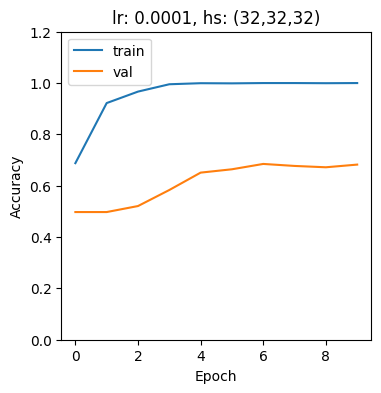

Final training accuracy: 1.0
Final validation accuracy: 0.682

7


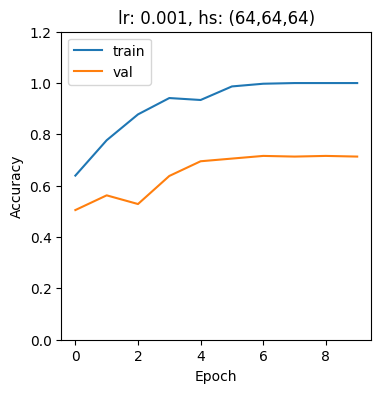

Final training accuracy: 1.0
Final validation accuracy: 0.714

8


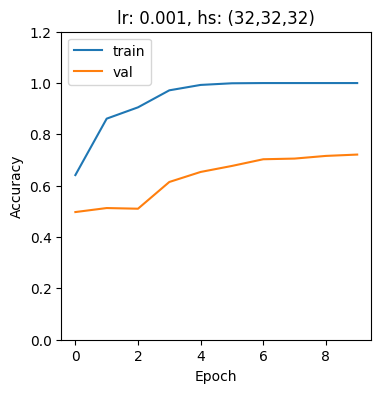

Final training accuracy: 1.0
Final validation accuracy: 0.721


In [243]:
lrs = [1e-04,1e-03]
hs=[(64,64,64),(32,32,32)]
catdog_shape = (150,150,3)
model_name = 'CatDog_model'

grid('CatDog_model', trn_iter_1, trn_stp_1, val_iter_1, val_stp_1, lrs, hs, 'sigmoid',catdog_shape,10,verbose=0)

In [ ]:
# Option 1: select best model generated from previous block of code
best_model_number, lr = 8, 1e-03
model_name = 'CatDog_model'

catdog_model_d = tf.keras.models.load_model(f'{root_dir}/{model_name}_{best_model_number}.hdf5')
catdog_model_d.compile(loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(lr=lr), 
                    metrics=['accuracy'])


# Option 2: load pre-trained model from shared folder (equivalent)
# catdog_model_d = tf.keras.models.load_model(cats_dogs_basic_cnn_loc)

### Evaluate performance

In [245]:
# Test evaluation
test_loss, test_acc = catdog_model_d.evaluate_generator(tst_iter_1,steps=tst_stp_1)
print('*** Test evaluation ***\n')
print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

*** Test evaluation ***

Test loss: 1.116
Test acc:  0.709


## (e) Visualize intermediate activations

In [246]:
# From lecture notes:

sample_image_path = dog_subset[0]
image = load_img(sample_image_path,target_size = (150,150))
image = img_to_array(image)
image = image.reshape(1,*image.shape)
image = (1./255)*image

layer_outputs = [layer.output for layer in catdog_model_d.layers]
activation_model = tf.keras.models.Model(inputs=catdog_model_d.input, outputs=layer_outputs)#
activations = activation_model.predict(image)

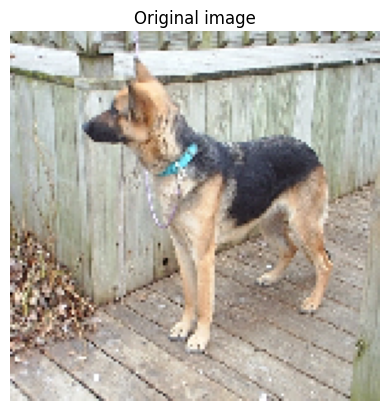

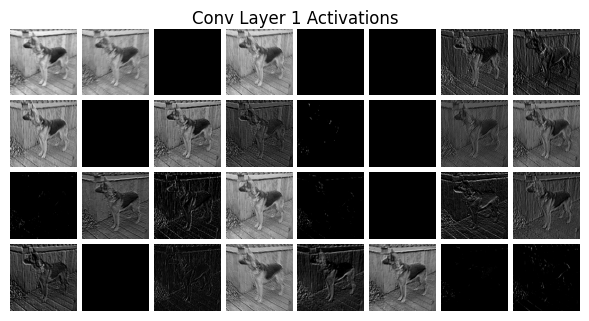

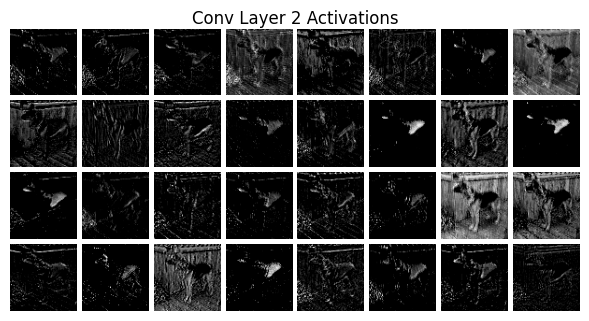

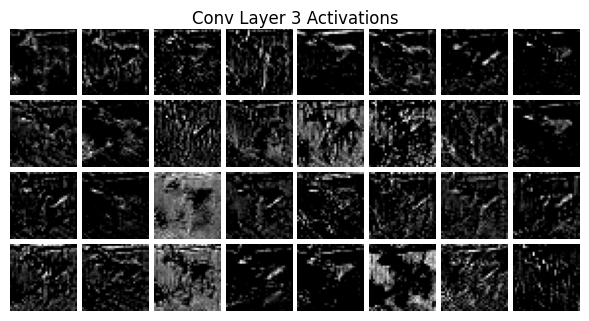

In [247]:
plt.imshow(image[0])
plt.title('Original image')
plt.axis('off')


for layer_number in range(3):

    intermediate_act = activations[layer_number*3]

    fig = plt.figure(figsize=(6., 6.))
    fig.suptitle(f'Conv Layer {layer_number+1} Activations')
    grid_ = ImageGrid(fig, 111,nrows_ncols=(4, 8),axes_pad=0.05)

    for ax,i in zip(grid_,range(32)):
        ax.imshow(intermediate_act[0,:,:,i],cmap = 'gray')
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(top=1.4)
    plt.show()

Activations in earlier layers tend to resemble the original image. Activations in deeper layers are more abstract and varied.

## Visualize filters

In [248]:
square_ = K.square
mean_   = K.mean
sqrt_   = K.sqrt

def deprocess_image(x):
    # normalize
    mean = x.mean()
    std  = x.std()
    x = (x-mean)/(std+1e-5)
    
    # scale/shift to range (0,1)
    x=x*0.1+0.5
    x = np.clip(x,0,1)
    
    # scale to range (0,255)
    x = x*255
    x = np.clip(x,0,255).astype('uint8')

    return x


def generate_pattern(layer_name,filter_index,size, layer_output, model_input):
    loss           = mean_(layer_output[:,:,:,filter_index])
    grads          = K.gradients(loss,model_input)[0]
    grads          = grads / (sqrt_(mean_(square_(grads))) + 1e-5)
    iterate        = K.function([model_input], [loss,grads])
    input_img_data = np.random.random((1,size,size,3))*20+128
   
    step=1
    for _ in range(40):
        loss_value,grads_value=iterate([input_img_data])
        input_img_data+=grads_value*step
       
    img=input_img_data[0]
    return deprocess_image(img)


Layer: conv2d_138
Shape: (None, 148, 148, 32)


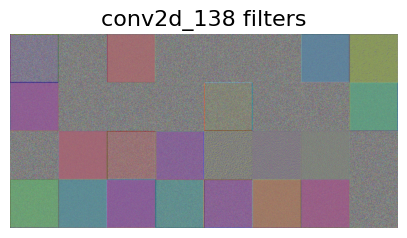


Layer: conv2d_139
Shape: (None, 72, 72, 32)


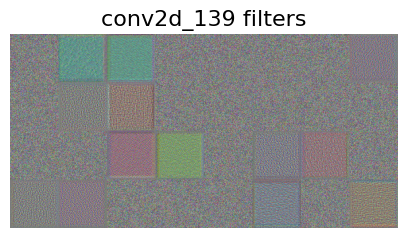


Layer: conv2d_140
Shape: (None, 34, 34, 32)


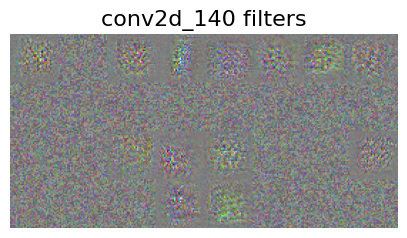

In [249]:
conv_layers = catdog_model_d.layers[0::3][:-1]
conv_layer_names = [l.name for l in conv_layers]
model_input = catdog_model_d.input

for (layer_name,layer) in zip(conv_layer_names, conv_layers):
    layer_output=layer.output
    print(f'\nLayer: {layer_name}\nShape: {layer_output.shape}')
    size=int(layer_output.shape[1])
    n_col= 8
    n_row = int(layer_output.shape[3]/n_col)
    filters=np.zeros((n_row*size,n_col*size,3),dtype=np.uint8)
    
   
    for i in range(n_row):
        for j in range(n_col):
            filter_img=generate_pattern(layer_name,i+(j*n_row),size, layer_output, model_input)        
            h0=i*size
            h1=h0+size
            v0=j*size
            v1=v0+size
            filters[h0:h1,v0:v1,:]=filter_img
    plt.figure(figsize=(5,5))
    plt.title(f'{layer_name} filters',fontsize=16)
    plt.imshow(filters)
    plt.savefig(f'{root_dir}/CatDog_{layer_name}_filters.png')
    plt.axis('off')
    plt.show()

Filters in early layers tend to show details of a pattern (like stripes), while filters from deeper layers tend to show a 'zoomed-out', big-picture shapes (like a cat). This trend is beginning to become apparent in the above images, although I think the filters would become more recognizable if there were more layers in the network.

## (g) Train with frozen VGG-16 convbase

In [294]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=catdog_shape)
display(conv_base.summary())

# build new model, replacing original conv layers with VGG conv layers

vgg_frozen = tf.keras.models.Sequential()
vgg_frozen.add(conv_base)
vgg_frozen.add(Flatten())
vgg_frozen.add(Dense(512,activation='relu'))
vgg_frozen.add(Dense(1,activation='sigmoid'))

# Freeze conv_base

print(f'Before freezing conv_base: {len(vgg_frozen.trainable_weights)} layers')
conv_base.trainable = False
print(f'After freezing conv_base:  {len(vgg_frozen.trainable_weights)} layers')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

None

Before freezing conv_base: 30 layers
After freezing conv_base:  4 layers


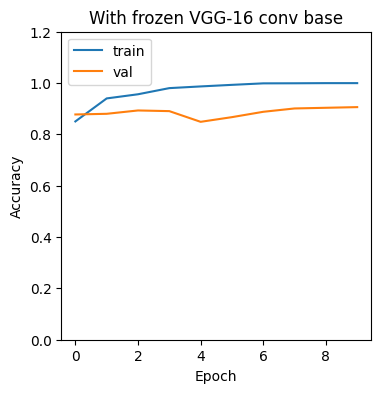

Final training accuracy: 1.0
Final validation accuracy: 0.906

Test loss: 0.352
Test acc:  0.907


In [295]:
epochs = 10
lr     = 1e-03
opt    = tf.keras.optimizers.Adam
model_name = 'VGG_frozen_model'

# compile
vgg_frozen.compile(loss='binary_crossentropy', optimizer=opt(lr=lr), metrics=['accuracy'])

# train
result = vgg_frozen.fit(trn_iter_1,
                        steps_per_epoch  = trn_stp_1,
                        epochs           = epochs,
                        validation_data  = val_iter_1,
                        validation_steps = val_stp_1,
                        workers=20,
                        verbose=0)

# save
vgg_frozen.save(f'{root_dir}/{model_name}.hdf5')
with open (f'{root_dir}/{model_name}_hist','wb') as f:
    pickle.dump(result.history,f)

plot_results(epochs,result,'With frozen VGG-16 conv base',f'{model_name}_plot.png')

print(f'Final training accuracy: {str(round(result.history["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(result.history["val_accuracy"][-1],3))}')

# Test evaluation

test_loss, test_acc = vgg_frozen.evaluate_generator(tst_iter_1,steps=tst_stp_1)
print()
print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

***Alternatively, evaluate pre-trained model from shared folder (equivalent)***

In [ ]:
# vgg_frozen = tf.keras.models.load_model(cats_dogs_frozen_vgg_loc)

# test_loss, test_acc = vgg_frozen.evaluate_generator(tst_iter_1,steps=tst_stp_1)
# print()
# print(f'Test loss: {str(np.round(test_loss,3))}')
# print(f'Test acc:  {str(np.round(test_acc,3))}')

## (h) Un-freeze conv base for fine tuning

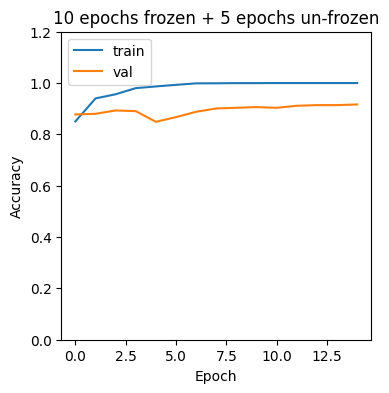

Final training accuracy: 1.0
Final validation accuracy: 0.917
*** Test evaluation ***

Test loss: 0.394
Test acc:  0.919


In [298]:
fine_tuning_model = tf.keras.models.load_model(f'{root_dir}/VGG_frozen_model.hdf5')
vgg_conv_base = fine_tuning_model.layers[0]
vgg_conv_base.trainable = True

epochs = 5
lr     = 1e-06
opt    = tf.keras.optimizers.Adam
model_name = 'VGG_fine_tuned_model'

# compile
fine_tuning_model.compile(loss='binary_crossentropy', optimizer=opt(lr=lr), metrics=['accuracy'])

# train
result_h = fine_tuning_model.fit(trn_iter_1,
                          steps_per_epoch=trn_stp_1,
                          epochs=epochs,
                          validation_data=val_iter_1,
                          validation_steps=val_stp_1,
                          workers=20,
                          verbose=0)

fine_tuning_model.save(f'{root_dir}/{model_name}.hdf5')
with open (f'{root_dir}/{model_name}_hist','wb') as f:
    pickle.dump(result_h.history,f)

both_dicts = {k:(result.history[k]+result_h.history[k]) for k in result.history.keys()}
plot_results(15,both_dicts,'10 epochs frozen + 5 epochs un-frozen',f'{model_name}_plot_2.png')
print(f'Final training accuracy: {str(round(both_dicts["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(both_dicts["val_accuracy"][-1],3))}')

test_loss, test_acc = fine_tuning_model.evaluate_generator(tst_iter_1,steps=tst_stp_1)
print('*** Test evaluation ***\n')
print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

***Alternatively, evaluate pre-trained model from shared folder (equivalent)***

In [301]:
# fine_tuning_model = tf.keras.models.load_model(cats_dogs_vgg_finetune_loc)

# test_loss, test_acc = fine_tuning_model.evaluate_generator(tst_iter_1,steps=tst_stp_1)
# print()
# print(f'Test loss: {str(np.round(test_loss,3))}')
# print(f'Test acc:  {str(np.round(test_acc,3))}')

## (i) VGG conv base + data augmentation

Found 3457 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 850 images belonging to 2 classes.


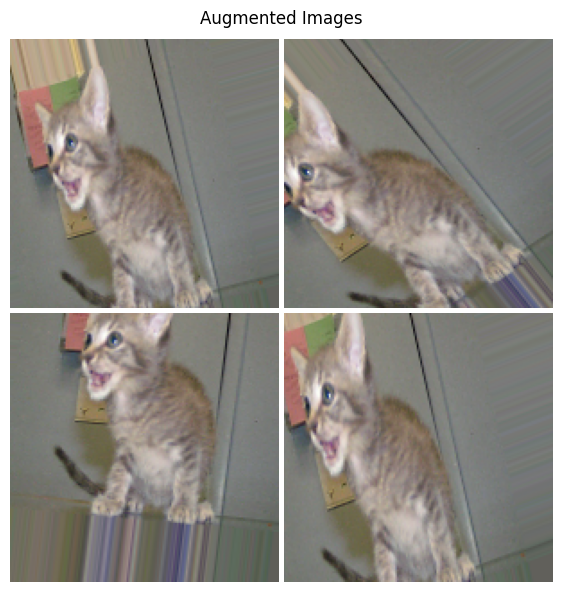

In [302]:
# From lecture notes:

trn_gen_1_aug = image_data_gen(aug=True)
val_gen_1_aug = image_data_gen(aug=True)
tst_gen_1_aug = image_data_gen(aug=True)

trn_iter_1_aug = trn_gen_1_aug.flow_from_directory(trn_dir_1, target_size=(150,150), batch_size=batch_size_1, class_mode="binary")
val_iter_1_aug = val_gen_1_aug.flow_from_directory(val_dir_1, target_size=(150,150), batch_size=batch_size_1, class_mode="binary")
tst_iter_1_aug = tst_gen_1_aug.flow_from_directory(tst_dir_1, target_size=(150,150), batch_size=batch_size_1, class_mode="binary")

# example: 
cat_dir = f'{root_dir}/task_1_data/train/Cat'
fs      = [f'{cat_dir}/{f}' for f in os.listdir(cat_dir)]
img     = load_img(fs[7], target_size=(150,150))
x       = img_to_array(img)
x       = x.reshape((1,) + x.shape)

fig = plt.figure(figsize=(6., 6.))
fig.suptitle(f'Augmented Images')
grid_ = ImageGrid(fig, 111,nrows_ncols=(2, 2),axes_pad=0.05)

for ax,batch in zip(grid_, trn_gen_1_aug.flow(x,batch_size=1)):
    ax.imshow(array_to_img(batch[0]))
    ax.axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

In [303]:
conv_base_aug = VGG16(weights='imagenet',include_top=False,input_shape=catdog_shape)

# build new model, replacing original conv layers with VGG conv layers
vgg_frozen_aug = tf.keras.models.Sequential()
vgg_frozen_aug.add(conv_base_aug)
vgg_frozen_aug.add(Flatten())
vgg_frozen_aug.add(Dense(512,activation='relu'))
vgg_frozen_aug.add(Dense(1,activation='sigmoid'))

# Freeze conv_base 
conv_base_aug.trainable = False

display(vgg_frozen_aug.summary())

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_65 (Flatten)        (None, 8192)              0         
                                                                 
 dense_92 (Dense)            (None, 512)               4194816   
                                                                 
 dense_93 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


None

In [304]:
trn_stp_1_aug = int(trn_iter_1_aug.samples/trn_iter_1_aug.batch_size)
val_stp_1_aug = int(val_iter_1_aug.samples/val_iter_1_aug.batch_size)
tst_stp_1_aug = int(tst_iter_1_aug.samples/tst_iter_1_aug.batch_size)

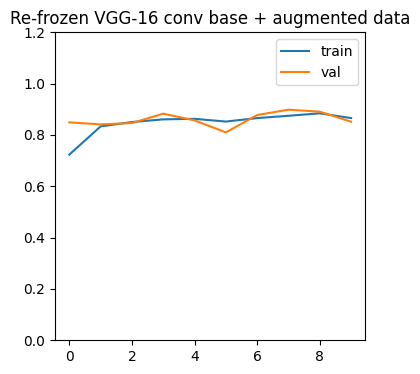

Final training accuracy: 0.866
Final validation accuracy: 0.852

Test loss: 0.342
Test acc:  0.846


In [309]:
epochs = 10
lr     = 1e-03
opt    = tf.keras.optimizers.Adam
model_name = 'VGG_aug_frozen_model_1e-03'

vgg_frozen_aug.compile(loss='binary_crossentropy', optimizer=opt(lr=lr), metrics=['accuracy'])

# train
vgg_frozen_aug_result = vgg_frozen_aug.fit(trn_iter_1_aug,
                        steps_per_epoch  = trn_stp_1_aug,
                        epochs           = epochs,
                        validation_data  = val_iter_1_aug,
                        validation_steps = val_stp_1_aug,
                        workers=20,
                        verbose=0)

# save
vgg_frozen_aug.save(f'{root_dir}/{model_name}.hdf5')
with open (f'{root_dir}/{model_name}_hist','wb') as f:
    pickle.dump(vgg_frozen_aug_result.history,f)

x,y1,y2 = range(epochs), vgg_frozen_aug_result.history['accuracy'], vgg_frozen_aug_result.history['val_accuracy']
plt.figure(figsize=(4,4))
plt.plot(x,y1,label='train')
plt.plot(x,y2,label='val')
plt.ylim(0,1.2)
plt.legend()
plt.title('Re-frozen VGG-16 conv base + augmented data')
plt.savefig(f'{root_dir}/{model_name}_figure.png')
plt.show()

print(f'Final training accuracy: {str(round(vgg_frozen_aug_result.history["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(vgg_frozen_aug_result.history["val_accuracy"][-1],3))}')

test_loss, test_acc = vgg_frozen_aug.evaluate_generator(tst_iter_1_aug, steps=tst_stp_1_aug)
print()
print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

***Alternatively, evaluate pre-trained model from shared folder (equivalent)***

In [ ]:
# vgg_frozen_aug = tf.keras.models.load_model(cats_dogs_data_augment_loc)

# test_loss, test_acc = vgg_frozen_aug.evaluate_generator(tst_iter_1,steps=tst_stp_1)
# print()
# print(f'Test loss: {str(np.round(test_loss,3))}')
# print(f'Test acc:  {str(np.round(test_acc,3))}')

# Task 2

## (a) Load data

In [40]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

data_zip = os.path.join(root_dir,'cifar-10-python.tar.gz')

f = tarfile.open(data_zip)
f.extractall(root_dir) 
f.close()

os.remove(data_zip)

--2022-11-09 05:54:01--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  10.2MB/s    in 22s     

2022-11-09 05:54:24 (7.30 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [41]:
cifar_labels     = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck',]
cifar_label_dict = dict(zip(range(10),cifar_labels))
cifar_shape      = (32,32,3)

print('CIFAR-10 labels:')
display(cifar_label_dict)

def output_label(y_array):
    idx = list(y_array).index(1)
    return cifar_label_dict[idx]

CIFAR-10 labels:


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

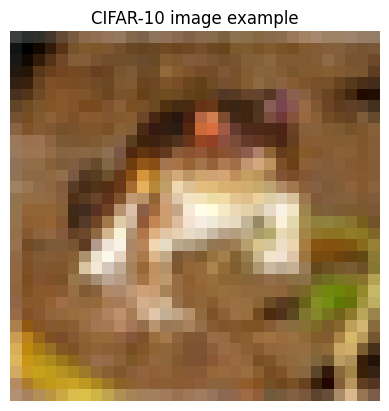

category: frog


In [157]:
def load_cifar_data(folder):
    train_batches = [f'{folder}/{f}' for f in os.listdir(folder) if 'batch_' in f]
    test_batch    =  f'{folder}/test_batch'

    # Get train data
    X_trn = None
    y_trn = []
    for i in range(len(train_batches)):
        train_data_dict = pickle.load(open(train_batches[i],'rb'), encoding='latin-1')
        if i+1 == 1:
            X_trn = train_data_dict['data']
        else:
            X_trn = np.vstack((X_trn, train_data_dict['data']))
        y_trn += train_data_dict['labels']
    X_trn = X_trn.reshape(len(X_trn),3,32,32)
    X_trn = np.rollaxis(X_trn,1,4)
    X_trn = X_trn.astype('float32')/255.0
    y_trn = np_utils.to_categorical(np.asarray(y_trn),10)

    # Get test data
    test_data_dict  = pickle.load(open(test_batch,'rb'), encoding='latin-1')
    X_tst = test_data_dict['data']
    X_tst = X_tst.reshape(len(X_tst),3,32,32)
    X_tst = np.rollaxis(X_tst,1,4)
    X_tst = X_tst.astype('float32')/255.0
    y_tst = np_utils.to_categorical(np.asarray(test_data_dict['labels']))
    
    n_90 = int(0.9*len(X_trn))
    X_trn, X_val = X_trn[:n_90], X_trn[n_90:]
    y_trn, y_val = y_trn[:n_90], y_trn[n_90:]

    return X_trn, y_trn, X_tst, y_tst, X_val, y_val

task_2_data_dir = f'{root_dir}/cifar-10-batches-py'
X_trn_c10, y_trn_c10, X_tst_c10, y_tst_c10, X_val_c10, y_val_c10 = load_cifar_data(task_2_data_dir)

plt.imshow(X_trn_c10[0])
plt.title('CIFAR-10 image example')
plt.axis('off')
plt.show()
print(f'category: {output_label(y_trn_c10[0])}')

## (b) Build basic CNN

In [158]:
batch_size_2 = 1024
    
trn_gen_2 = image_data_gen()
val_gen_2 = image_data_gen()
tst_gen_2 = image_data_gen()

trn_iter_2 = trn_gen_2.flow(X_trn_c10,y_trn_c10,batch_size=batch_size_2)
tst_iter_2 = tst_gen_2.flow(X_tst_c10,y_tst_c10,batch_size=batch_size_2)
val_iter_2 = val_gen_2.flow(X_val_c10,y_val_c10,batch_size=batch_size_2)

trn_stp_2 = int(len(X_trn_c10)/trn_iter_2.batch_size)
tst_stp_2 = int(len(X_tst_c10)/tst_iter_2.batch_size)
val_stp_2 = int(len(X_val_c10)/val_iter_2.batch_size)

### Grid search


11


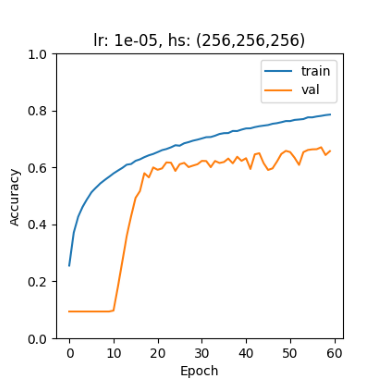

Final training accuracy: 0.785
Final validation accuracy: 0.657

12


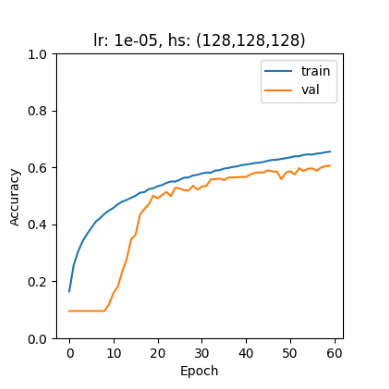

Final training accuracy: 0.655
Final validation accuracy: 0.605


In [261]:
lrs = [1e-05]
hs  = [(256,256,256),(128,128,128)]


grid('cifar_model_', trn_iter_2, trn_stp_2, val_iter_2, val_stp_2, lrs, hs, 'softmax', cifar_shape, 60,verbose=0)

In [184]:
# Option 1: select best model generated from previous block of code

best_model_number = 11
model_name = 'cifar_model_'
cifar_model_c = tf.keras.models.load_model(f'{root_dir}/{model_name}_{best_model_number}.hdf5')

# Option 2: load pre-trained model from shared folder (equivalent)
# cifar_model_c = tf.keras.models.load_model(cifar_basic_cnn_loc)

In [185]:
# Test evaluation
test_loss, test_acc = cifar_model_c.evaluate_generator(tst_iter_2,steps=tst_stp_2)
print('*** Test evaluation ***\n')
print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

*** Test evaluation ***

Test loss: 1.014
Test acc:  0.651


## (d) Inception Blocks

In [255]:
def inception_block(input_, h=64):
    _1_1_conv = Conv2D(h,(1,1),activation='relu')(input_)

    _3_3_conv = Conv2D(h,(1,1),activation='relu')(input_)
    _3_3_conv = Conv2D(h,(3,3),activation='relu',padding='same')(_3_3_conv)

    _5_5_conv = Conv2D(h,(1,1),activation='relu')(input_)
    _5_5_conv = Conv2D(h,(3,3),activation='relu',padding='same')(_5_5_conv)

    _2_2_maxpool = MaxPool2D((2,2))(input_)
    _2_2_maxpool = Conv2D(h,(1,1),activation='relu')(input_)

    concat_ = tf.keras.layers.concatenate([_1_1_conv, _3_3_conv, _5_5_conv, _2_2_maxpool])
    
    return concat_

In [256]:
(h1,h2,h3) = (256,256,256) 

Input_layer = Input(shape=cifar_shape)

conv__1 = Conv2D(h1,(3,3),activation='relu')(Input_layer)
pool__1 = MaxPool2D((2,2))(conv__1)
bnorm_1 = BatchNormalization()(pool__1)

conv__2 = Conv2D(h2,(3,3),activation='relu')(bnorm_1)
pool__2 = MaxPool2D((2,2))(conv__2)
bnorm_2 = BatchNormalization()(pool__2)
incep_2 = inception_block(bnorm_2)

conv__3 = Conv2D(h3,(3,3),activation='relu')(incep_2)
pool__3 = MaxPool2D((2,2))(conv__3)
bnorm_3 = BatchNormalization()(pool__3)

flat = Flatten()(bnorm_3)          
out  = Dense(10,activation='softmax')(flat)

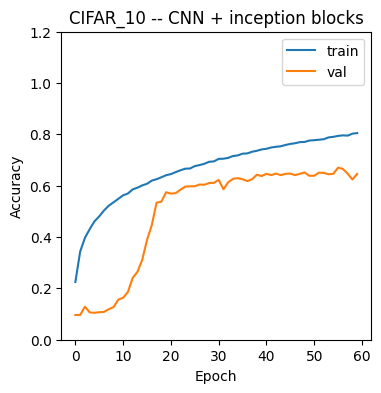

In [257]:
cifar_inception_model = tf.keras.Model(inputs=Input_layer, outputs=out)

lr=1e-05
opt=tf.keras.optimizers.Adam
epochs=60

model_name = 'cifar_inception_model'


cifar_inception_model.compile(loss='categorical_crossentropy', 
                              optimizer=opt(lr=lr), 
                              metrics=['accuracy'])

# train
result = cifar_inception_model.fit(trn_iter_2,
                                   steps_per_epoch=trn_stp_2,
                                   epochs=epochs,
                                   validation_data=val_iter_2,
                                   validation_steps=val_stp_2,
                                   workers=20,
                                   verbose=0)


cifar_inception_model.save(f'{root_dir}/{model_name}.hdf5')

with open (f'{root_dir}/{model_name}_hist','wb') as f:
    pickle.dump(result.history,f)
    
plot_results(epochs,result,'CIFAR_10 -- CNN + inception blocks',f'{model_name}.png')
print(f'Final training accuracy: {str(round(result.history["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(result.history["val_accuracy"][-1],3))}')

In [ ]:
# Option 1: evaluate model generated from previous block of code (no change necessary)
# Option 2: load pre-trained model from shared folder before evaluating on test set. Uncomment:
# cifar_inception_model = tf.keras.models.load_model(cifar_inception_loc)

# (equivalent methods)

In [277]:
model_name = 'cifar_inception_model'
with open (f'{root_dir}/{model_name}_hist','rb') as f:
    result=pickle.load(f)

print(f'Final training accuracy: {str(round(result["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(result["val_accuracy"][-1],3))}')

test_loss, test_acc = cifar_inception_model.evaluate_generator(tst_iter_2,steps=tst_stp_2)
print()

print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

Final training accuracy: 0.805
Final validation accuracy: 0.646

Test loss: 1.037
Test acc:  0.64


## (e) Residual Blocks

In [190]:
(h1,h2,h3) = (256,256,256) 

input____1 = Input(shape=cifar_shape)

output___1 = Conv2D(h1,(3,3),activation='relu',padding='same')(input____1)
output___1 = MaxPool2D((2,2))(output___1)
output___1 = BatchNormalization()(output___1)


residual_1 = Conv2D(h1,1,strides=2,padding='same')(input____1)
input____2 = tf.keras.layers.add([residual_1, output___1])


output___2 = Conv2D(h2,(3,3),activation='relu',padding='same')(input____2)
output___2 = MaxPool2D((2,2))(output___1)
output___2 = BatchNormalization()(output___1)


residual_2 = input____2 
input____3 = tf.keras.layers.add([residual_2, output___2])


output___3 = Conv2D(h3,(3,3),activation='relu',padding='same')(input____3)
output___3 = MaxPool2D((2,2))(output___3)
output___3 = BatchNormalization()(output___3)

flat = Flatten()(output___3)          
out  = Dense(10,activation='softmax')(flat)

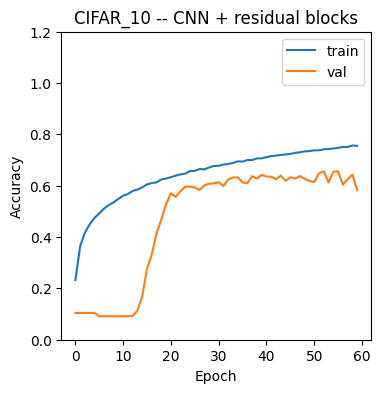

In [191]:
cifar_residual_model = tf.keras.Model(inputs=input____1, outputs=out)

lr=1e-05
opt=tf.keras.optimizers.Adam
epochs=60

model_name = 'cifar_residual_model'


# compile 
cifar_residual_model.compile(loss='categorical_crossentropy', 
                             optimizer=opt(lr=lr), 
                             metrics=['accuracy'])

# train
cifar_residual_result = cifar_residual_model.fit(trn_iter_2,
                                                 steps_per_epoch=trn_stp_2,
                                                 epochs=epochs,
                                                 validation_data=val_iter_2,
                                                 validation_steps=val_stp_2,
                                                 workers=20,
                                                 verbose=0)

# save
cifar_residual_model.save(f'{root_dir}/{model_name}.hdf5')

with open (f'{root_dir}/{model_name}_hist','wb') as f:
    pickle.dump(cifar_residual_result.history,f)
    
plot_results(epochs,cifar_residual_result,'CIFAR_10 -- CNN + residual blocks',f'{model_name}.png')
print(f'Final training accuracy: {str(round(cifar_residual_result.history["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(cifar_residual_result.history["val_accuracy"][-1],3))}')


In [ ]:
# Option 1: evaluate model generated from previous block of code (no change necessary)
# Option 2: load pre-trained model from shared folder before evaluating on test set. Uncomment:
# cifar_residual_model = tf.keras.models.load_model(cifar_residual_loc)

# (equivalent methods)

In [274]:
print(f'Final training accuracy: {str(round(cifar_residual_result.history["accuracy"][-1],3))}')
print(f'Final validation accuracy: {str(round(cifar_residual_result.history["val_accuracy"][-1],3))}')

# Test evaluation
test_loss, test_acc = cifar_residual_model.evaluate_generator(tst_iter_2,steps=tst_stp_2)
print()
print(f'Test loss: {str(np.round(test_loss,3))}')
print(f'Test acc:  {str(np.round(test_acc,3))}')

Final training accuracy: 0.755
Final validation accuracy: 0.583

Test loss: 1.171
Test acc:  0.592
